## 목차
### 1.RFM 분석을 위한 EDA

In [24]:
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
df = pd.read_csv('/content/drive/MyDrive/낭만부부/analysis/final_nmbb.csv')

In [122]:
df_add = pd.read_excel("/content/drive/MyDrive/낭만부부/analysis/sales_add.xlsx")

In [123]:
df = pd.concat([df, df_add])
df.shape

(7117, 48)

In [124]:
def get_month_int(dframe, column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month, day

In [125]:
df_new = df[['결제일', '주문번호', '구매자명', '구매자ID', '상품번호', '상품명', '판매자 부담 할인액',
             '상품별 총 주문금액', '배송비 합계', '정산예정금액']]

In [126]:
df_name = df_new.copy()

In [127]:
# '구매자명'에 마스킹처리
def mask_name(name):
    if len(name) == 2:
        return name[0] + '*'
    elif len(name) == 3:
        return name[0] + '**'
    else:
        return name

df_name['구매자명'] = df_name['구매자명'].apply(mask_name)

In [128]:
# 고객ID 부여
df_name['고객ID'] = df_name.groupby(['구매자명', '구매자ID']).ngroup()
df_name.head()

,결제일,주문번호,구매자명,구매자ID,상품번호,상품명,판매자 부담 할인액,상품별 총 주문금액,배송비 합계,정산예정금액,고객ID
0,2023-04-21 17:59:15,2023042110123081,송**,ha*********,6911507810,낭만부부 치즈몽땅 떡볶이 540g (치즈떡+만두+소스 밀키트),3560,14240,3000,13810,1013
1,2023-04-22 09:29:57,2023042218053241,박**,wi****,5892185888,낭만부부 꼬마가래떡 235g,0,5800,0,5250,849
2,2023-04-22 09:29:57,2023042218053241,박**,wi****,4788778377,낭만부부 햅쌀 떡국떡 1kg,0,15000,0,14547,849
3,2023-04-21 17:59:15,2023042110123081,송**,ha*********,6911541023,구워먹는 치즈바 530g (오리지널/단호박/흑임자),1780,7120,3000,6905,1013
4,2023-04-22 04:42:40,2023042216489621,문**,mh*****,4788783431,낭만부부 모짜렐라 치즈 가래떡 500g,9780,25820,0,27700,645


In [129]:
df_name['결제일'] = pd.to_datetime(df_name['결제일'])

In [130]:
result_df = df_name.groupby(['고객ID']).agg({
    '상품별 총 주문금액': 'sum',
    '결제일': ['min', 'max'],  # 각 주문에 대한 최소 및 최대 주문일을 가져옴
}).reset_index()

In [131]:
result_df

고객ID 상품별 총 주문금액                 결제일                    
                  sum                 min                 max
0        0      39900 2023-10-13 13:24:48 2023-10-13 13:24:48
1        1      16020 2023-04-09 23:51:43 2023-04-09 23:51:43
2        2      41400 2023-03-07 23:21:34 2023-03-07 23:21:34
3        3      24500 2023-08-30 17:50:28 2023-09-13 15:24:33
4        4       7600 2024-01-13 20:09:39 2024-01-13 20:09:39
...    ...        ...                 ...                 ...
2307  2307      25550 2024-02-03 19:10:37 2024-02-03 19:10:37
2308  2308      12300 2023-11-20 08:36:17 2023-11-20 08:36:17
2309  2309      31600 2023-10-22 12:45:06 2023-10-22 12:45:06
2310  2310      17800 2023-09-20 16:15:07 2023-09-20 16:15:07
2311  2311      27300 2023-07-27 02:35:17 2023-07-27 02:35:17

[2312 rows x 4 columns]

In [132]:
order_count_by_customer = df_name.groupby('고객ID')['주문번호'].nunique().reset_index()
order_count_by_customer.columns = ['고객ID', '고객별 총 주문수']

In [133]:
result_df = pd.merge(result_df, order_count_by_customer, on='고객ID', how='left')

In [140]:
result_df

,고객ID,"(고객ID, )","(상품별 총 주문금액, sum)","(결제일, min)","(결제일, max)",고객별 총 주문수
0,0,0,39900,2023-10-13 13:24:48,2023-10-13 13:24:48,1
1,1,1,16020,2023-04-09 23:51:43,2023-04-09 23:51:43,1
2,2,2,41400,2023-03-07 23:21:34,2023-03-07 23:21:34,1
3,3,3,24500,2023-08-30 17:50:28,2023-09-13 15:24:33,2
4,4,4,7600,2024-01-13 20:09:39,2024-01-13 20:09:39,1
...,...,...,...,...,...,...
2307,2307,2307,25550,2024-02-03 19:10:37,2024-02-03 19:10:37,1
2308,2308,2308,12300,2023-11-20 08:36:17,2023-11-20 08:36:17,1
2309,2309,2309,31600,2023-10-22 12:45:06,2023-10-22 12:45:06,1
2310,2310,2310,17800,2023-09-20 16:15:07,2023-09-20 16:15:07,1


In [143]:
result_df = result_df[[ '고객ID', ('상품별 총 주문금액', 'sum'),'고객별 총 주문수',('결제일', 'min'),('결제일', 'max')]]

In [144]:
result_df

,고객ID,"(상품별 총 주문금액, sum)",고객별 총 주문수,"(결제일, min)","(결제일, max)"
0,0,39900,1,2023-10-13 13:24:48,2023-10-13 13:24:48
1,1,16020,1,2023-04-09 23:51:43,2023-04-09 23:51:43
2,2,41400,1,2023-03-07 23:21:34,2023-03-07 23:21:34
3,3,24500,2,2023-08-30 17:50:28,2023-09-13 15:24:33
4,4,7600,1,2024-01-13 20:09:39,2024-01-13 20:09:39
...,...,...,...,...,...
2307,2307,25550,1,2024-02-03 19:10:37,2024-02-03 19:10:37
2308,2308,12300,1,2023-11-20 08:36:17,2023-11-20 08:36:17
2309,2309,31600,1,2023-10-22 12:45:06,2023-10-22 12:45:06
2310,2310,17800,1,2023-09-20 16:15:07,2023-09-20 16:15:07


In [142]:
from datetime import datetime, timedelta

In [146]:
result_df['첫구매'] = result_df[('결제일', 'min')].dt.date
result_df['마지막구매'] = result_df[('결제일', 'max')].dt.date

In [ ]:
result_df.rename(columns = ('상품별 총 주문금액', 'sum'):'총주문액', inplace = True)

In [154]:
result_df = result_df[['고객ID', '총주문액', '고객별 총 주문수', '첫구매', '마지막구매']]
result_df.head()

,고객ID,총주문액,고객별 총 주문수,첫구매,마지막구매
0,0,39900,1,2023-10-13,2023-10-13
1,1,16020,1,2023-04-09,2023-04-09
2,2,41400,1,2023-03-07,2023-03-07
3,3,24500,2,2023-08-30,2023-09-13
4,4,7600,1,2024-01-13,2024-01-13


## 재구매 관련 작업
- 구매 주기 컬럼 추가
- 구매주기 계산식: (마지막 구매 - 첫구매) / 고객별 총 주문 수

## 재구매자 확인
- 재구매고객 정의: 2회 이상 구매 이력 있는 고객
- 재구매 고객들의 평균 주문수/ 주문수 중앙값 : **2회**
- 재구매 고객들의 재구매주기: **약 40일**

In [155]:
result_df['재구매주기'] = (result_df['마지막구매'] - result_df['첫구매']) / result_df['고객별 총 주문수']

In [156]:
result_df.head()

,고객ID,총주문액,고객별 총 주문수,첫구매,마지막구매,재구매주기
0,0,39900,1,2023-10-13,2023-10-13,0 days
1,1,16020,1,2023-04-09,2023-04-09,0 days
2,2,41400,1,2023-03-07,2023-03-07,0 days
3,3,24500,2,2023-08-30,2023-09-13,7 days
4,4,7600,1,2024-01-13,2024-01-13,0 days


In [158]:
repurch = result_df[result_df['고객별 총 주문수'] > 1]
repurch

,고객ID,총주문액,고객별 총 주문수,첫구매,마지막구매,재구매주기
3,3,24500,2,2023-08-30,2023-09-13,7 days 00:00:00
9,9,65280,3,2023-04-16,2023-11-16,71 days 08:00:00
12,12,236800,10,2023-06-11,2023-12-07,17 days 21:36:00
14,14,111700,3,2023-09-19,2024-02-01,45 days 00:00:00
20,20,88450,2,2023-06-02,2024-01-23,117 days 12:00:00
...,...,...,...,...,...,...
2285,2285,432200,2,2023-09-04,2023-10-24,25 days 00:00:00
2291,2291,47700,2,2023-06-20,2023-06-25,2 days 12:00:00
2294,2294,86200,3,2023-02-10,2023-10-20,84 days 00:00:00
2295,2295,70000,4,2023-06-23,2023-12-05,41 days 06:00:00


In [159]:
repurch.describe()

,고객ID,총주문액,고객별 총 주문수,재구매주기
count,566.000000,566.000000,566.000000,566
mean,1084.992933,83400.141343,2.726148,50 days 03:22:46.097930338
std,678.943224,52464.111698,1.246981,39 days 17:50:52.294239652
min,3.000000,17800.000000,2.000000,0 days 00:00:00
25%,442.750000,53250.000000,2.000000,16 days 12:36:00
50%,1031.500000,68925.000000,2.000000,44 days 14:00:00
75%,1673.750000,97012.500000,3.000000,71 days 17:06:00
max,2298.000000,432200.000000,10.000000,190 days 00:00:00


## RFM
- Recency: 최근 결제일 컬럼 추가
- Frequency: 재구매 여부 (재구매: 2회 이상 구매)
- Moneytary: 평균 결제금액 27600원

### 정의할 부분과 계산해야되는 부분
- 재구매 정의: n일 이내의 구매
- 주기별 구매한 user의 수
- 주기별 구매한 금액의 계산

### RECENCY 기준
- 기준점이 2개로 (or 조건 적용)
  1. 재구매주기 40일 이내
    - 40일인 이유: 재구매 주기 중앙값이 40일임.
  2. 데이터 추출한 기점:2024년 1월 31일 기준으로, 최근 결제일이 3개월 이내이면

### FREQUENCY 기준
- 전체 고객의 총주문횟수의 평균값은 1.4회이며, 중앙값은 1회였다.
- 하지만, 적어도 2회 이상 구매한 고객이 가치있기 때문에
- Frequency 기준점을 **2회**로 선정

In [161]:
aggre = {
    '결제일':'max',
    '주문번호': 'nunique',
    '상품별 총 주문금액':'sum'
}

cust_df = df_name.groupby(['고객ID']).agg(aggre)

In [162]:
cust_df = cust_df.rename(columns = {
    '결제일':'Recency',
    '주문번호':'Frequency',
    '상품별 총 주문금액':'Moneytary'
})
cust_df = cust_df.reset_index()
cust_df.head(3)

,고객ID,Recency,Frequency,Moneytary
0,0,2023-10-13 13:24:48,1,39900
1,1,2023-04-09 23:51:43,1,16020
2,2,2023-03-07 23:21:34,1,41400


In [56]:
#size(): 각 그룹에 속하는 행의 수
unique_combinations = df_name.groupby(['구매자ID', '구매자명']).size().reset_index(name='Count')
unique_combination_count = unique_combinations.shape[0]

print(f"유니크한 ID와 구매자명 조합의 개수: {unique_combination_count}")

유니크한 ID와 구매자명 조합의 개수: 2312


In [57]:
unique_combinations.nunique()

구매자ID    1366
구매자명       88
Count      23
dtype: int64

In [58]:
unique_combinations.head()

,구매자ID,구매자명,Count
0,00*****,이**,4
1,00*******,공**,2
2,01********,임**,2
3,01*********,장**,2
4,01*********,정**,3


In [164]:
aggre = {
    '결제일':'max', #최근 주문일
    '주문번호': 'nunique', #distinct, 총 주문 횟수
    '상품별 총 주문금액':'sum' #총 주문 금액
}

cust_df = df_name.groupby(['고객ID']).agg(aggre)

In [166]:
cust_df = cust_df.rename(columns = {
    '결제일':'최근결제일',
    '주문번호':'주문빈도',
    '상품별 총 주문금액':'누적주문액'
})
cust_df = cust_df.reset_index()
cust_df.head()

,고객ID,최근결제일,주문빈도,누적주문액
0,0,2023-10-13 13:24:48,1,39900
1,1,2023-04-09 23:51:43,1,16020
2,2,2023-03-07 23:21:34,1,41400
3,3,2023-09-13 15:24:33,2,24500
4,4,2024-01-13 20:09:39,1,7600


In [167]:
cust_df['최근결제일'] = pd.to_datetime(cust_df['최근결제일'])

In [168]:
# recency 컬럼 가공
# 마지막 구매 경과일
import datetime as dt

current_date = dt.datetime(2024, 1, 31)

cust_df['Recency'] = current_date - cust_df['최근결제일']
cust_df['Recency'] = cust_df['Recency'].dt.days + 1
cust_df.head()

,고객ID,최근결제일,주문빈도,누적주문액,Recency
0,0,2023-10-13 13:24:48,1,39900,110
1,1,2023-04-09 23:51:43,1,16020,297
2,2,2023-03-07 23:21:34,1,41400,330
3,3,2023-09-13 15:24:33,2,24500,140
4,4,2024-01-13 20:09:39,1,7600,18


In [169]:
cust_df['1회평균결제금액'] = cust_df['누적주문액'] / cust_df['주문빈도']

In [170]:
cust_df.head()

,고객ID,최근결제일,주문빈도,누적주문액,Recency,1회평균결제금액
0,0,2023-10-13 13:24:48,1,39900,110,39900.0
1,1,2023-04-09 23:51:43,1,16020,297,16020.0
2,2,2023-03-07 23:21:34,1,41400,330,41400.0
3,3,2023-09-13 15:24:33,2,24500,140,12250.0
4,4,2024-01-13 20:09:39,1,7600,18,7600.0


In [72]:
cust_df['최근결제일'] = pd.to_datetime(cust_df['최근결제일'])

In [80]:
cust_df = cust_df[(cust_df['최근결제일'] < '2024-02-01 00:00:00') & (cust_df['최근결제일'] > '2023-01-31 00:00:20')]

In [81]:
cust_df['1회평균결제금액'] = cust_df['누적주문액'] / cust_df['주문빈도']
cust_df.describe()

,고객ID,주문빈도,누적주문액,Recency,1회평균결제금액
count,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000
mean,1153.607897,1.404500,39866.749311,168.291552,27532.032868
std,669.034108,0.937808,36464.661430,108.778726,14558.858901
min,0.000000,1.000000,3600.000000,0.000000,3600.000000
25%,571.250000,1.000000,18300.000000,72.000000,17800.000000
50%,1151.500000,1.000000,30900.000000,154.000000,27600.000000
75%,1736.750000,1.000000,44275.000000,268.000000,34800.000000
max,2311.000000,10.000000,432200.000000,365.000000,267000.000000


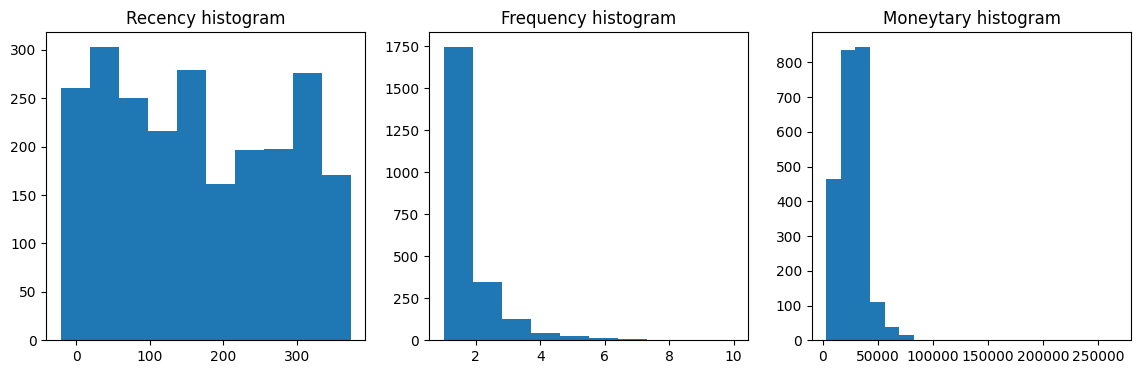

In [171]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14,4), nrows =1, ncols =3)
ax1.set_title('Recency histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency histogram')
ax2.hist(cust_df['주문빈도'])

ax3.set_title('Moneytary histogram')
ax3.hist(cust_df['1회평균결제금액'], bins = 20)

plt.show()

### 객단가 확인하기!
- 전체 고객: 27,500원
- 재구매 고객: 30,000원

In [179]:
result_df

,고객ID,총주문액,고객별 총 주문수,첫구매,마지막구매,재구매주기,최근구매이력,재구매여부
0,0,39900,1,2023-10-13,2023-10-13,0 days,105 days,0
1,1,16020,1,2023-04-09,2023-04-09,0 days,292 days,0
2,2,41400,1,2023-03-07,2023-03-07,0 days,325 days,0
3,3,24500,2,2023-08-30,2023-09-13,7 days,135 days,1
4,4,7600,1,2024-01-13,2024-01-13,0 days,13 days,0
...,...,...,...,...,...,...,...,...
2307,2307,25550,1,2024-02-03,2024-02-03,0 days,-8 days,0
2308,2308,12300,1,2023-11-20,2023-11-20,0 days,67 days,0
2309,2309,31600,1,2023-10-22,2023-10-22,0 days,96 days,0
2310,2310,17800,1,2023-09-20,2023-09-20,0 days,128 days,0


In [ ]:
result_df.rename(columns = {('상품별 총 주문금액', 'sum'):'총주문액'}, inplace = True)

<ipython-input-83-7a585bb229c6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df.rename(columns = {('상품별 총 주문금액', 'sum'):'총주문액'}, inplace = True)


In [ ]:
result_df['1회평균_주문액'] = result_df['총주문액'] / result_df['고객별 총 주문수']

<ipython-input-84-d3958d0411c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['1회평균_주문액'] = result_df['총주문액'] / result_df['고객별 총 주문수']


In [ ]:
result_df.head()

,고객ID,총주문액,고객별 총 주문수,첫구매,마지막구매,1회평균_주문액
0,0,39900,1,2023-10-13,2023-10-13,39900.0
1,1,16020,1,2023-04-09,2023-04-09,16020.0
2,2,41400,1,2023-03-07,2023-03-07,41400.0
3,3,24500,2,2023-08-30,2023-09-13,12250.0
4,4,7600,1,2024-01-13,2024-01-13,7600.0


In [ ]:
# 재구매자만 고려했을때 1회 주문시 주문액 = 30,000원
monetary_2 = result_df[result_df['고객별 총 주문수'] > 1]
monetary_2.describe()

,고객ID,총주문액,고객별 총 주문수,1회평균_주문액
count,497.00000,497.000000,497.000000,497.000000
mean,1035.89336,82161.871227,2.704225,30106.319760
std,642.89651,52284.879390,1.247191,12936.403063
min,3.00000,17800.000000,2.000000,8900.000000
25%,423.00000,52600.000000,2.000000,23250.000000
50%,998.00000,68400.000000,2.000000,30150.000000
75%,1609.00000,95500.000000,3.000000,35600.000000
max,2162.00000,432200.000000,10.000000,216100.000000


In [ ]:
# 모든 구매자 고려
# 평균: 27,500원
# 중앙값: 27,800원
result_df.describe()

,고객ID,총주문액,고객별 총 주문수,1회평균_주문액
count,2174.000000,2174.000000,2174.000000,2174.000000
mean,1086.500000,39440.285189,1.389604,27539.821031
std,627.724064,36559.406038,0.931379,14546.705046
min,0.000000,3600.000000,1.000000,3600.000000
25%,543.250000,18070.000000,1.000000,17800.000000
50%,1086.500000,30800.000000,1.000000,27800.000000
75%,1629.750000,42375.000000,1.000000,34800.000000
max,2173.000000,432200.000000,10.000000,267000.000000


In [ ]:
# 1회 구매자 only: 26,700원
monetary_1 = result_df[result_df['고객별 총 주문수'] == 1]
monetary_1.describe()

,고객ID,총주문액,고객별 총 주문수,1회평균_주문액
count,1677.000000,1677.000000,1677.0,1677.000000
mean,1101.497913,26779.206917,1.0,26779.206917
std,622.561466,14909.661210,0.0,14909.661210
min,0.000000,3600.000000,1.0,3600.000000
25%,586.000000,17600.000000,1.0,17600.000000
50%,1111.000000,26700.000000,1.0,26700.000000
75%,1635.000000,34400.000000,1.0,34400.000000
max,2173.000000,267000.000000,1.0,267000.000000


In [191]:
result_df

,고객ID,총주문액,고객별 총 주문수,첫구매,마지막구매,재구매주기,최근구매이력,재구매여부
0,0,39900,1,2023-10-13,2023-10-13,0 days,110 days,0
1,1,16020,1,2023-04-09,2023-04-09,0 days,297 days,0
2,2,41400,1,2023-03-07,2023-03-07,0 days,330 days,0
3,3,24500,2,2023-08-30,2023-09-13,7 days,140 days,1
4,4,7600,1,2024-01-13,2024-01-13,0 days,18 days,0
...,...,...,...,...,...,...,...,...
2307,2307,25550,1,2024-02-03,2024-02-03,0 days,-3 days,0
2308,2308,12300,1,2023-11-20,2023-11-20,0 days,72 days,0
2309,2309,31600,1,2023-10-22,2023-10-22,0 days,101 days,0
2310,2310,17800,1,2023-09-20,2023-09-20,0 days,133 days,0


In [196]:
result_df['마지막구매'] = pd.to_datetime(result_df['마지막구매'])
result_df['첫구매'] = pd.to_datetime(result_df['첫구매'])

In [194]:
result_df = result_df[(result_df['마지막구매'] < '2024-02-01 00:00:00') & (result_df['마지막구매'] > '2023-01-31 00:00:20')]

In [181]:
result_df['재구매여부'] = result_df['재구매주기'].apply(lambda x: 0 if x == timedelta(days=0) else 1)

In [200]:
result_df.head()

,고객ID,총주문액,고객별 총 주문수,첫구매,마지막구매,재구매주기,최근구매이력,재구매여부
0,0,39900,1,2023-10-13,2023-10-13,0 days,110 days,0
1,1,16020,1,2023-04-09,2023-04-09,0 days,297 days,0
2,2,41400,1,2023-03-07,2023-03-07,0 days,330 days,0
3,3,24500,2,2023-08-30,2023-09-13,7 days,140 days,1
4,4,7600,1,2024-01-13,2024-01-13,0 days,18 days,0


In [203]:
result_df['재구매여부'].value_counts()

0    1674
1     502
Name: 재구매여부, dtype: int64

### Monetary 기준
- **객단가**와 **누적 주문금액** 중
- ### **누적 주문금액**을 Monetary 기준으로 세움
- 총주문액의 평균값인 4만원 이상인 고객 수 확인: 605명
- 전체주문 중 4만원 이상의 주문은 **전체의 28%** 차지.

In [207]:
result_df.describe()

,고객ID,총주문액,고객별 총 주문수,재구매주기,최근구매이력,재구매여부
count,2176.000000,2176.000000,2176.000000,2176,2176,2176.000000
mean,1152.874540,39875.496324,1.404871,11 days 14:12:44.023109243,168 days 02:39:29.117647058,0.230699
std,668.893308,36476.486391,0.938159,28 days 01:17:18.680216684,108 days 15:57:34.440679672,0.421377
min,0.000000,3600.000000,1.000000,0 days 00:00:00,0 days 00:00:00,0.000000
25%,570.750000,18300.000000,1.000000,0 days 00:00:00,72 days 00:00:00,0.000000
50%,1150.500000,30900.000000,1.000000,0 days 00:00:00,154 days 00:00:00,0.000000
75%,1735.250000,44225.000000,1.000000,0 days 00:00:00,268 days 00:00:00,0.000000
max,2311.000000,432200.000000,10.000000,178 days 12:00:00,364 days 00:00:00,1.000000


In [208]:
result_df[result_df['총주문액'] > 40000]

,고객ID,총주문액,고객별 총 주문수,첫구매,마지막구매,재구매주기,최근구매이력,재구매여부
2,2,41400,1,2023-03-07,2023-03-07,0 days 00:00:00,330 days,0
9,9,65280,3,2023-04-16,2023-11-16,71 days 08:00:00,76 days,1
12,12,236800,10,2023-06-11,2023-12-07,17 days 21:36:00,55 days,1
20,20,88450,2,2023-06-02,2024-01-23,117 days 12:00:00,8 days,1
22,22,41700,1,2023-02-26,2023-02-26,0 days 00:00:00,339 days,0
...,...,...,...,...,...,...,...,...
2286,2286,41400,1,2023-03-25,2023-03-25,0 days 00:00:00,312 days,0
2291,2291,47700,2,2023-06-20,2023-06-25,2 days 12:00:00,220 days,1
2294,2294,86200,3,2023-02-10,2023-10-20,84 days 00:00:00,103 days,1
2295,2295,70000,4,2023-06-23,2023-12-05,41 days 06:00:00,57 days,1


In [209]:
len(result_df)-622

1554

In [210]:
622/len(result_df)

0.2858455882352941

In [ ]:
cycle['재구매주기'] = (cycle['마지막구매'] - cycle['첫구매']) / cycle['고객별 총 주문수']

In [ ]:
cycle['재구매주기'].describe()

count                           497
mean     45 days 12:47:58.674544888
std      35 days 14:04:09.576471389
min          0 days 00:00:16.500000
25%                16 days 08:14:16
50%                39 days 10:04:46
75%         67 days 13:36:48.500000
max               159 days 16:12:01
Name: 재구매주기, dtype: object